In [1]:
import numpy as np
import sys, time
import os
import argparse
import sbitools
import emcee
import torch



/mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')
%matplotlib inline
import yaml


# autoreload modules
%load_ext autoreload
%autoreload 2

import matplotlib
%matplotlib inline



In [3]:
# x_all.shape
pk_type = 'all'
do_wavelets = 's0_s1_s2'

import pickle as pk
val_loss_all = np.zeros(256)
for ji in range(256):
    try:
        df = pk.load(open(f'/mnt/home/spandey/ceph/CHARM/charm/sweep/output/trained_summary_pk_{pk_type}_bk_wavelets_{do_wavelets}/saved_{ji}.pkl','rb'))
        val_loss_all[ji] = df['best_validation_log_prob']
    except:
        pass

ind_best = np.flip(np.argsort(val_loss_all))

indsel_analysis = ind_best[:5]
print(indsel_analysis)




[125 102  55  27  18]


In [4]:
import dill
posteriors_all = []
for ji in indsel_analysis:
    fname = f'/mnt/home/spandey/ceph/CHARM/charm/sweep/output/trained_posteriors_pk_{pk_type}_bk_wavelets_{do_wavelets}/saved_{ji}.pkl'
    with open(fname, 'rb') as f:
        data = dill.load(f)
    posteriors_all.append(data['posterior'])
    print(ji, data['summary']['best_validation_log_prob'])


125 21.079775674002512
102 20.50869791848319
55 19.79279468677662
27 19.42564732687814
18 19.214498585668103


In [5]:
# x_all.shape, x_all_truth.shape, theta_all.shape
# saved = {'x_all': x_all, 'x_all_truth': x_all_truth, 'theta_all': theta_all}
import pickle as pk
# pk.dump(saved, open('/mnt/home/spandey/ceph/CHARM/charm/sweep/data/saved_data_all.pk', 'wb'))
saved = pk.load(open(f'/mnt/home/spandey/ceph/CHARM/charm/sweep/data/saved_data_pk_{pk_type}_bk_wavelets_{do_wavelets}.pk','rb'))
x_all = saved['x_all'][18000:,:]
x_all_truth = saved['x_all_truth'][18000:,:]
theta_all = saved['theta_all'][18000:,:]

ldir = f'/mnt/home/spandey/ceph/CHARM/charm/sweep/output/trained_posteriors_pk_{pk_type}_bk_wavelets_{do_wavelets}/'
scaler = pk.load(open(ldir + 'scaler.pkl', 'rb'))
x_all = scaler.transform(x_all)
x_all_truth = scaler.transform(x_all_truth)

ind_all = np.arange(x_all.shape[0])
nrand_sel = 200
ind_sel_post = np.random.choice(ind_all, nrand_sel, replace=False)

x_all_truth_sel = x_all_truth[ind_sel_post,:]
theta_all_sel = theta_all[ind_sel_post,:]






In [6]:
prior = sbitools.sbi_prior(theta_all, offset=0.05)



In [7]:
from sbi.utils.posterior_ensemble import NeuralPosteriorEnsemble
posterior = NeuralPosteriorEnsemble(posteriors=posteriors_all)



In [8]:
from tqdm import tqdm
nsamples = 1000
samples_all_isims = np.zeros((nrand_sel, 1000, theta_all_sel.shape[-1]))
true_all_isims = np.zeros((nrand_sel, theta_all_sel.shape[-1]))

for ji in tqdm(range(nrand_sel)):
    x = x_all_truth_sel[ji]
    samples = posterior.sample((nsamples,), x=torch.from_numpy(x.astype('float32')), show_progress_bars=False).detach().numpy()
    samples_all_isims[ji] = samples
    true_all_isims[ji] = theta_all_sel[ji]



100%|██████████| 200/200 [02:07<00:00,  1.57it/s]


In [9]:
samples_all_tarp = np.moveaxis(samples_all_isims, 0, 1)
true_all_tarp = true_all_isims


samples_all_mean = np.mean(samples_all_tarp, axis = 0)
samples_all_std = np.std(samples_all_tarp, axis = 0)




In [10]:
# import tarp
import sys, os
sys.path.append('/mnt/home/spandey/ceph/tarp/src/tarp')
import drp
references = "random"
metric = 'euclidean'
bootstrap= True
norm = True
num_alpha_bins = None
num_bootstrap = 10


ecp, alpha = drp.get_tarp_coverage(
            samples_all_tarp[:,:, :], true_all_tarp[:,:],
            references=references, metric=metric,
            norm=norm, bootstrap=bootstrap,
            num_alpha_bins=num_alpha_bins,
            num_bootstrap=num_bootstrap
        )
        



100%|██████████| 10/10 [00:00<00:00, 29.70it/s]


In [11]:
Om_min = 0.135
Om_max = 0.49
sig8_min = 0.61
sig8_max = 0.99
indsel = np.where((true_all_tarp[:,0] > Om_min) & (true_all_tarp[:,0] < Om_max) & (true_all_tarp[:,4] > sig8_min) & (true_all_tarp[:,4] < sig8_max))[0]


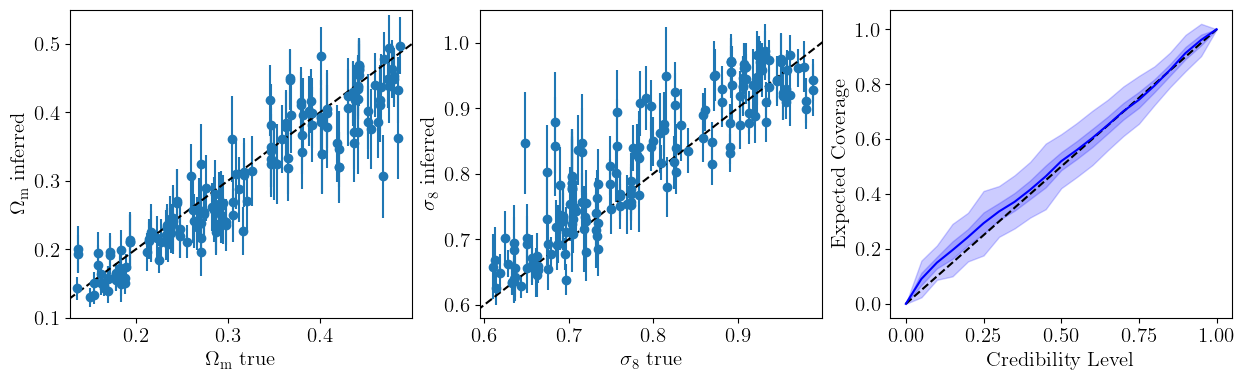

In [14]:
fig, ax = pl.subplots(1, 3, figsize=(15, 4))
ax[0].errorbar(true_all_tarp[indsel,0], samples_all_mean[indsel,0], yerr = samples_all_std[indsel,0], fmt = 'o')
# ax[0].errorbar(Om_true_all[indsel], samples_all_tarp_mean[indsel,0], yerr = samples_all_tarp_std[indsel,0], fmt = 'o')
ax[0].plot([0.8*Om_min, 1.2*Om_max], [0.8*Om_min, 1.2*Om_max], 'k--')
ax[0].set_xlim([0.95*Om_min, 1.02*Om_max])
ax[0].set_ylim([0.1, 0.55])
# ax[0].set_ylim([Om_min, Om_max])
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].tick_params(axis='both', which='minor', labelsize=15)
ax[0].set_xlabel(r'$\Omega_{\rm m}$ true', size=15)
ax[0].set_ylabel(r'$\Omega_{\rm m}$ inferred', size=15)

ax[1].errorbar(true_all_tarp[indsel, 4], samples_all_mean[indsel,4], yerr = samples_all_std[indsel,4], fmt = 'o')
ax[1].plot([0.8*sig8_min, 1.2*sig8_max], [0.8*sig8_min, 1.2*sig8_max], 'k--')
ax[1].set_xlim([0.975*sig8_min, 1.01*sig8_max])
ax[1].set_ylim([0.58, 1.05])
# ax[1].set_ylim([sig8_min, sig8_max])
ax[1].set_xlabel(r'$\sigma_8$ true', size=15)
ax[1].set_ylabel(r'$\sigma_8$ inferred', size=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='minor', labelsize=15)

ax = ax[2]
ax.plot([0, 1], [0, 1], ls='--', color='k')
if bootstrap:
    ecp_mean = np.mean(ecp, axis=0)
    ecp_std = np.std(ecp, axis=0)
    ax.plot(alpha, ecp_mean, label='TARP', color='b')
    ax.fill_between(alpha, ecp_mean - ecp_std, ecp_mean + ecp_std,
                    alpha=0.2, color='b')
    ax.fill_between(alpha, ecp_mean - 3 * ecp_std, ecp_mean + 3 * ecp_std,
                    alpha=0.2, color='b')
else:
    ax.plot(alpha, ecp, label='TARP')
# ax.legend()
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
ax.set_ylabel("Expected Coverage", size=15)
ax.set_xlabel("Credibility Level", size=15)
pl.savefig(f'/mnt/home/spandey/ceph/CHARM/results/paper_plots/Om_sig8_coverage_pk_{pk_type}_bk_wavelets_{do_wavelets}.pdf', bbox_inches='tight')




In [26]:
# torch.Tensor(x_all_truth_sel[indtest])



tensor([ 5.3718e+04,  3.9422e+04,  2.5619e+04,  1.8339e+04,  1.2499e+04,
         9.3584e+03,  7.2728e+03,  5.5780e+03,  4.6187e+03,  3.9941e+03,
         3.5176e+03,  3.2134e+03,  3.0529e+03,  3.5040e+04,  1.7887e+04,
         9.3353e+03,  3.7615e+03,  2.4252e+03,  1.9507e+03,  1.2335e+03,
         5.8922e+02,  1.7945e+02,  1.2630e+02, -7.6487e+01, -1.2356e+02,
         3.5304e+00,  1.9757e+04,  5.4308e+03,  6.2807e+03, -2.0014e+03,
        -4.5530e+02,  2.6748e+02,  6.4549e+02,  8.3262e+01,  1.9375e+02,
         2.5959e+02,  7.1402e+01,  1.1621e+02,  2.0517e+02,  6.7190e+08,
         6.4649e+08,  6.9601e+08,  7.5517e+08,  7.9495e+08,  1.3137e+09,
         5.7109e+07,  6.5271e+07,  7.1095e+07,  6.7945e+07,  1.1591e+08,
         1.8859e+08,  1.1935e+07,  9.4241e+06,  8.8793e+06,  9.3388e+06,
         1.0307e+07,  2.6768e+07,  8.2532e-01,  3.4651e-01,  3.6812e-01,
         1.0423e+00,  3.1322e-02,  6.0259e-01,  3.9378e-01,  2.9782e-01,
         1.3840e-01,  1.7417e-01,  3.2916e-01,  5.9